# The Bird Reservoir

## Présentation du dataset

Il s'agit d'un ensemble de données d'enregistrements sonores d'oiseaux, un sous-ensemble spécifique recueilli à partir de la collection Xeno Canto pour former un ensemble de données équilibré couvrant 88 espèces couramment entendues au Royaume-Uni.

Lien vers les données : https://www.kaggle.com/datasets/rtatman/british-birdsong-dataset

In [98]:
%pip install librosa soundfile

Note: you may need to restart the kernel to use updated packages.


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import soundfile as sf



In [100]:
# Téléchargement des données
df = pd.read_csv("..//songs//birdsong_metadata.csv") # Remplacez par le chemin correct vers le fichier CSV
df.head()
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 264 rows and 10 columns


In [101]:
# Prise de connaissance des données
df.head(5)

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/


Le "genus", l'espèce et le nom anglais sont équivalents. Nous utiliserons le "genus" comme label principal.

In [102]:
# Fonction de chargement et de traitement audio
def load_audio(file_id):
    data, samplerate = sf.read("../songs/songs/xc"+str(file_id)+".flac")
    s = len(data)/samplerate
    sg = librosa.feature.melspectrogram(
        y=data,
        sr=samplerate,
        hop_length=512)
    
    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:,centerpoint].mean()
    
    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0)>=M/20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0,len(mask)):
        audio_mask[i*512:] = mask[i]
    return sg, mask, data, audio_mask, samplerate

#### Visualisation d'un fichier audio

In [103]:
# Test de la fonction load_audio
sg, mask, data, audio_mask, sr = load_audio(99299)

print("Sampling rate :", sr)
print("Durée (s) :", len(data)/sr)
print("Spectrogram shape :", sg.shape)

Sampling rate : 44100
Durée (s) : 31.007120181405895
Spectrogram shape : (128, 2671)


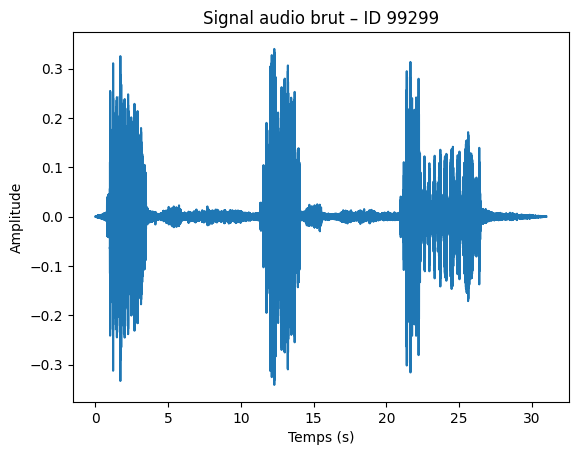

In [104]:
# Plot du signal temporel
t = np.arange(len(data)) / sr

plt.figure()
plt.plot(t, data)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.title("Signal audio brut – ID 99299")
plt.show()

##### Visualisation du spectrogramme Mel
L’échelle Mel est logarithmique à haute fréquence et linéaire à basse fréquence.
Elle permet de voir le son comme l’oreille humaine, compressé et exploitable pour un modèle.

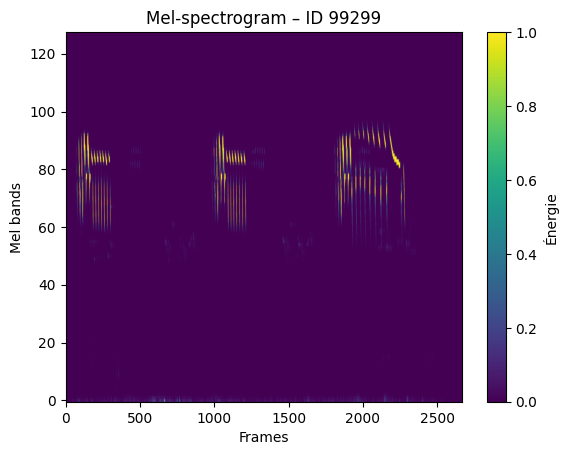

In [105]:
plt.figure()
plt.imshow(
    sg,
    aspect="auto",
    origin="lower",
    vmin=0,     # valeur min affichée
    vmax=1,  # valeur max affichée
    cmap="viridis"
)
plt.colorbar(label="Énergie")
plt.xlabel("Frames")
plt.ylabel("Mel bands")
plt.title("Mel-spectrogram – ID 99299")
plt.show()

##### Visualisaion masque d'énérgie

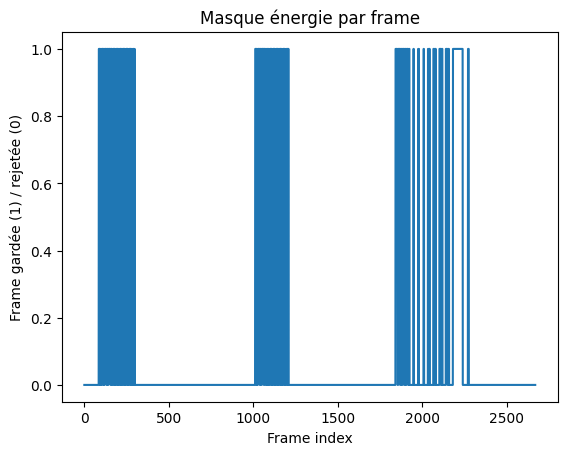

In [106]:
plt.figure()
plt.plot(mask.astype(int))
plt.xlabel("Frame index")
plt.ylabel("Frame gardée (1) / rejetée (0)")
plt.title("Masque énergie par frame")
plt.show()

C:\Users\amand\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


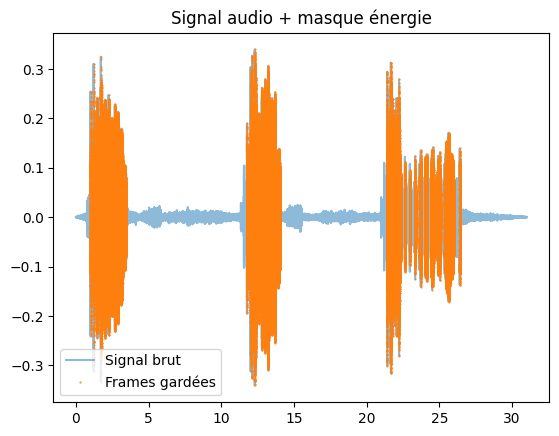

In [107]:
# Masque projeté sur le signal temporel
plt.figure()
plt.plot(t, data, label="Signal brut", alpha=0.5)
plt.plot(t[audio_mask], data[audio_mask], '.', label="Frames gardées", markersize=1)
plt.legend()
plt.title("Signal audio + masque énergie")
plt.show()

Le masque permet de ne garder que les parties “actives” du son. Il garde uniquement les frames dont l’énergie est ≥ 5% de l'amplitude moyenne.

In [108]:
# Téléchargement et traitement des fichiers audio
df['length'] = np.zeros(len(df))

waves = {}


for file_id in df['file_id']:
    sg, mask, data, audio_mask, sample_rate = load_audio(file_id)
    waves[file_id] = data[audio_mask]
    df.loc[df['file_id'] == file_id,'length'] = len(data[audio_mask])
    # print(len(data[audio_mask])/sample_rate)

In [116]:
df['length'].describe()

count    2.640000e+02
mean     4.307546e+05
std      6.611052e+05
min      6.144000e+03
25%      1.000960e+05
50%      2.373120e+05
75%      4.424960e+05
max      5.286262e+06
Name: length, dtype: float64

In [111]:
n_windows = df.groupby('species')['windows'].sum().min()
n_windows

np.int64(20)

In [117]:
# First we create all windows for each file and partition them by species

windows = {}

for file_id in df['file_id']:
    wave = waves[file_id]
    species = df[df['file_id']==file_id]['genus'].values[0] + "_" + df[df['file_id']==file_id]['species'].values[0]
    if species not in windows:
        windows[species] = []
    for i in range(0, int(len(wave)/6.144000e+03)):
        windows[species].append(wave[i:int(i+6.144000e+03)])

#### Visualisation

In [113]:
import matplotlib.pyplot as plt

### Pré-traitement de l'audio

## Classification avec un réservoir

## Interprétation des résultats